In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [4]:
transformed_path = '/Users/markos98/aquasteady_research/data/transformed/'
important_features = pd.read_csv(transformed_path + 'important_features.csv')
important_features = important_features.set_index('AREA')

# Cluster analysis to see what regions may stray from the trend

In [275]:
cluster = important_features
cols = cluster.columns[1:100]
for col in cols:
    cluster[col] = cluster[col].replace('', 'NaN').astype(str).str.replace(',', '').astype(float)

In [276]:
cluster.head()

,Risk of reduced yield or poorer crop quality (2023),Cannot finance improvements (2023),Cannot finance improvements (2018),Risk of reduced yield or poorer crop quality (2013),Physical field or crop conditions limit system improvements (2013),Cannot finance improvements (2013),Risk of reduced yield or poorer crop quality (2003),Physical field or crop conditions limit system improvements (2003),Cannot finance improvements (2003),Will not be farming this operation long enough to justify improvements (2003)
AREA,,,,,,,,,,
United States,6367477.0,8636826.0,8834795.0,5208860.0,6443086.0,7625049.0,4708089.0,4379816.0,8318070.0,1798301.0
Alabama,17730.0,27342.0,9425.0,7215.0,10302.0,13144.0,7593.0,4032.0,10012.0,904.0
Alaska,122.0,162.0,574.0,40.0,96.0,137.0,NaN,0.0,995.0,NaN
Arizona,150187.0,160323.0,201683.0,67194.0,90073.0,121436.0,43359.0,52928.0,104168.0,35365.0
Arkansas,424880.0,802832.0,683527.0,383750.0,631712.0,765831.0,363468.0,215570.0,761984.0,237606.0


In [277]:
X = cluster.values

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

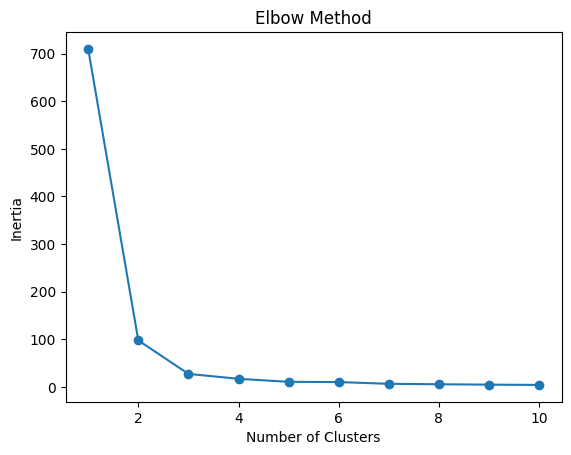

In [278]:
inertia = []
for i in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [279]:
#2 must be the best number of clusters

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)
labels = kmeans.labels_

kmeans.fit(X)
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.94


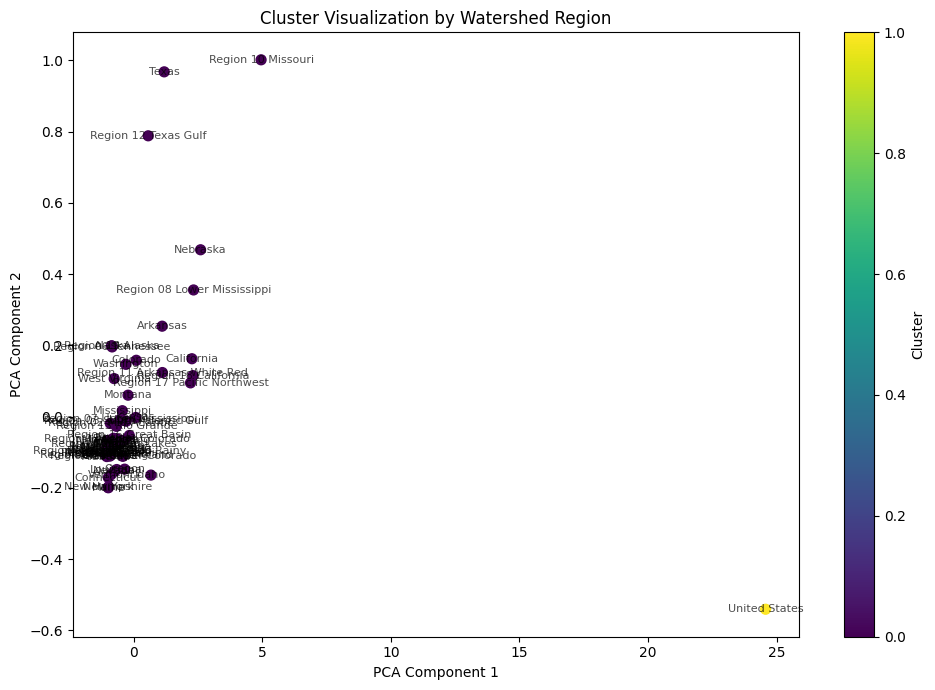

In [280]:
# Get the last 20 index labels
last_20_labels = cluster.index[-20:]

# PCA and plotting (same as before)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")

# Annotate ONLY the last 20 points
for i, label in enumerate(cluster.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], label, 
                 fontsize=8, alpha=0.7, ha='center', va='center')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization by Watershed Region')
plt.tight_layout()
plt.show()

#### Fortunately, the states and regions seems to match up (CA with CA, Texas Gulf with Texas).

#### Texas Gulf, Missouri, California, and Lower Mississippi watersheds are the most singular regions and warrant further investigation.

# Stacked line chart to see final trend

#### The most significant features are Finances, Physical Crop Conditions and Risk of Reduced Yield, so I will plot them together. 
#### The least significant regions--7, 12, 3, and 19--will be removed. 
#### I will use the mean of the remaining regions

In [38]:
chart = pd.read_csv(path + 'chart.csv')

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import Q
import seaborn as sns

In [41]:
formula = "Q('Risk of reduced yield or poorer crop quality') ~ Year"

model = smf.ols(formula, data=chart).fit()

model.summary()

/Volumes/Mac/opt/anaconda3/envs/aquasteady/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     Q('Risk of reduced yield or poorer crop quality')   R-squared:                       0.824
Model:                                                           OLS   Adj. R-squared:                  0.737
Method:                                                Least Squares   F-statistic:                     9.394
Date:                                               Wed, 09 Apr 2025   Prob (F-statistic):             0.0920
Time:                                                       19:01:55   Log-Likelihood:                -45.432
No. Observations:                                                  4   AIC:                             94.86
Df Residuals:                                                      2   BIC:                             93.64
Df Model:                                                          1                                         
Covariance Type:                                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.193e+07   3.99e+06     -2.989      0.096   -2.91e+07    5.24e+06
Year        6074.0889   1981.773      3.065      0.092   -2452.791    1.46e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.664
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.889
Skew:                           1.099   Prob(JB):                        0.641
Kurtosis:                       2.292   Cond. No.                     5.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, '( (Y)')

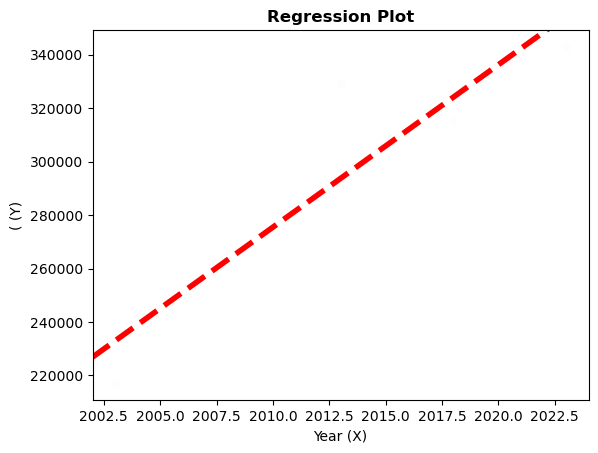

In [43]:
ax = sns.scatterplot(y=model.model.endog,
                     x=model.model.exog[:,1], alpha=0.01)
sm.graphics.abline_plot(model_results=model, color='red',
                        linewidth=4, linestyle='--', ax=ax)
plt.title("Regression Plot", fontweight="bold")
plt.xlabel(f"{model.model.exog_names[1]} (X)")
plt.ylabel(f"{model.model.endog_names[1]} (Y)")